In [108]:
import importlib
from __imports__ import *
import data, LSTM_returns, optimization
importlib.reload(data)

<module 'data' from 'c:\\Users\\27904\\OneDrive\\桌面\\crypto\\AAA_Thursday1\\data\\__init__.py'>

In [109]:
df = data.load_asset('DOGEUSDT', sampling='1d')
df = data.add_fear_and_greed(df)
# Restrict data after 2022
df = df[df.index >= '2022-01-01']
df.head()

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,F&G,F&G category
Open time,,,,,,,,,,,
2022-01-01,0.1703,0.1737,0.1697,0.1732,2.975041e+08,5.111861e+07,78125,158466283.0,2.723658e+07,21.0,Extreme Fear
2022-01-02,0.1731,0.1763,0.1705,0.1745,3.129559e+08,5.423202e+07,103674,163325748.0,2.830660e+07,29.0,Fear
2022-01-03,0.1745,0.1745,0.1674,0.1703,4.609854e+08,7.876928e+07,139249,236643465.0,4.045470e+07,29.0,Fear
2022-01-04,0.1703,0.1726,0.1665,0.1684,4.964392e+08,8.444579e+07,127545,258358537.0,4.396345e+07,23.0,Extreme Fear
2022-01-05,0.1685,0.1710,0.1472,0.1590,1.084632e+09,1.755868e+08,307998,519468771.0,8.434797e+07,24.0,Extreme Fear


In [110]:
import ta  # technical analysis library

look_back = 14

# Return: Daily log return
df['Return'] = np.log(df['Close'] / df['Close'].shift(1))

# Risk: Rolling standard deviation of returns (volatility)
df['Risk'] = df['Return'].rolling(window=look_back).std()

# RSI: Relative Strength Index
df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=look_back).rsi()

# ADX: Average Directional Index
df['ADX'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=look_back).adx()

# MOM: Momentum indicator (difference between close and n periods ago)
df['MOM'] = df['Close'] - df['Close'].shift(look_back)

# HL: High-Low spread (volatility proxy)
df['HL'] = df['High'] - df['Low']

# HO: High-Open gap
df['HO'] = df['High'] - df['Open']

# LO: Low-Open gap
df['LO'] = df['Low'] - df['Open']

df['buy_pressure_ratio'] = df['Taker buy quote asset volume'] / df['Quote asset volume']
df['trades_per_volume'] = df['Number of trades'] / df['Quote asset volume']

def compute_slope(series):
    y = series.values
    x = np.arange(len(y))
    if len(y) == 0:
        return np.nan
    slope = np.polyfit(x, y, 1)[0]
    return slope

# Assume df['Close'] already exists
df['slope'] = df['Close'].rolling(window=look_back).apply(compute_slope, raw=False)

# Drop rows with NaN due to indicator lookback
df = df.dropna()

# Show result
print(df[['Return', 'Risk', 'RSI', 'ADX', 'MOM', 'HL', 'HO', 'LO']].head())

              Return      Risk        RSI  ADX     MOM      HL      HO      LO
Open time                                                                     
2022-01-15  0.007071  0.042587  67.072693  0.0  0.0113  0.0133  0.0116 -0.0017
2022-01-16 -0.043762  0.044473  57.845138  0.0  0.0021  0.0113  0.0002 -0.0111
2022-01-17 -0.033394  0.044930  52.170343  0.0  0.0005  0.0128  0.0018 -0.0110
2022-01-18 -0.033942  0.045777  47.263105  0.0 -0.0033  0.0127  0.0035 -0.0092
2022-01-19 -0.022046  0.043358  44.421160  0.0  0.0025  0.0107  0.0045 -0.0062


In [111]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume',
       'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume', 'F&G', 'F&G category', 'Return', 'Risk',
       'RSI', 'ADX', 'MOM', 'HL', 'HO', 'LO', 'buy_pressure_ratio',
       'trades_per_volume', 'slope'],
      dtype='object')

In [112]:
cols_to_drop = ['Open', 'High', 'Low', 'Quote asset volume',
       'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume','F&G', ]  # add more columns if needed

df = df.drop(columns=cols_to_drop)

In [113]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [114]:
# for next-day close price:
df['target_close'] = df['Close'].shift(-1)

# or for next-day return:
df['target_ret'] = df['Return'].shift(-1)

# drop the last row (it has no next-day value)
df = df.dropna(subset = ['target_ret'])   # or ['target_ret']

df = pd.get_dummies(df, columns=['F&G category'], prefix='FG_cat')

In [115]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# pick your shifted target:
target_col = 'target_ret'    # or 'target_ret'

# redefine your features list to include the new dummy columns
features = [
    'Close', 'Volume', 'Return', 'Risk', 'RSI', 'ADX', 'MOM', 'HL',
    'HO', 'LO', 'buy_pressure_ratio', 'trades_per_volume', 'slope'
] + [c for c in df.columns if c.startswith('FG_cat_')]

X = df[features]
y = df[target_col]

# train/test split (no stratify for regression)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# instantiate a regressor
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# evaluate
preds = model.predict(X_test)
mse  = mean_squared_error(y_test, preds)    # default returns MSE
rmse = np.sqrt(mse)                         # now you have RMSE

print("Test RMSE:", rmse)

Test RMSE: 0.056893719508619024


In [116]:
imp = model.get_booster().get_score(importance_type='gain')
imp_df = (
    pd.DataFrame({'feature':list(imp.keys()), 'gain':list(imp.values())})
    .sort_values('gain', ascending=False)
)
print(imp_df.head(100))


                 feature      gain
14  FG_cat_Extreme Greed  0.008378
7                     HL  0.005141
5                    ADX  0.004990
4                    RSI  0.004824
10    buy_pressure_ratio  0.004784
8                     HO  0.004456
11     trades_per_volume  0.004200
2                 Return  0.004151
9                     LO  0.004054
12                 slope  0.003896
1                 Volume  0.003814
13   FG_cat_Extreme Fear  0.003737
6                    MOM  0.003652
0                  Close  0.003503
16          FG_cat_Greed  0.003502
3                   Risk  0.003396
17        FG_cat_Neutral  0.003330
15           FG_cat_Fear  0.002731


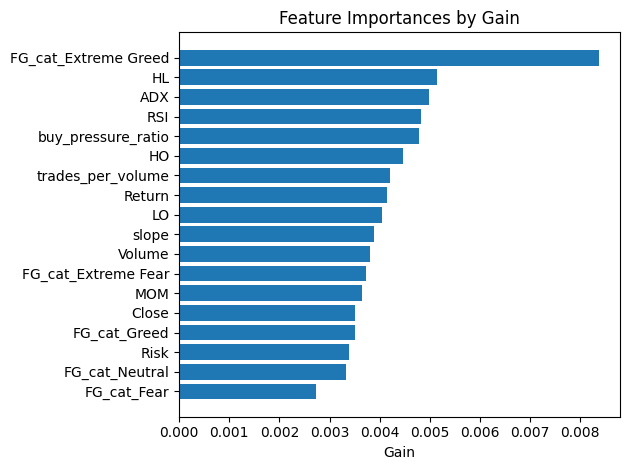

In [117]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Recompute importances from your XGBoost model
imp = model.get_booster().get_score(importance_type='gain')
imp_df = pd.DataFrame({
    'feature': list(imp.keys()),
    'gain':    list(imp.values())
}).sort_values('gain', ascending=False).reset_index(drop=True)

# 2) Horizontal bar chart of feature importances
plt.figure()
plt.barh(imp_df['feature'], imp_df['gain'])
plt.xlabel('Gain')
plt.title('Feature Importances by Gain')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

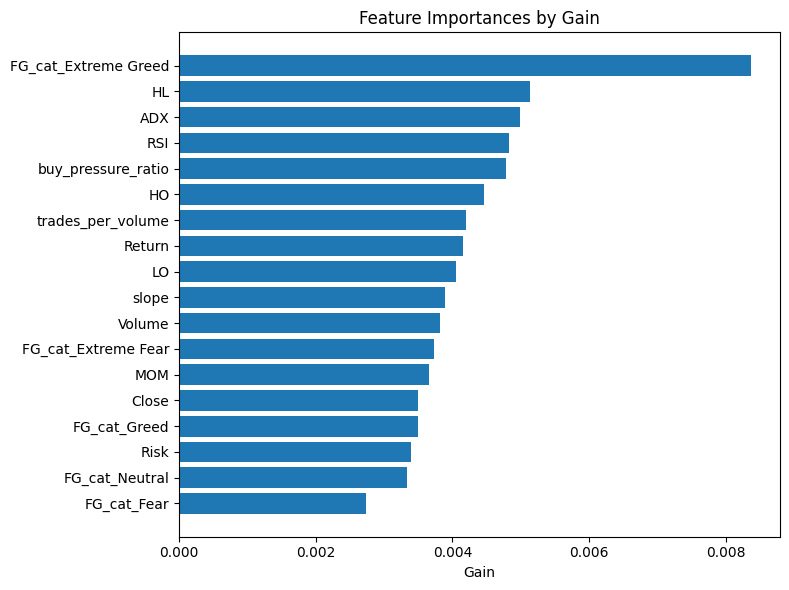

In [118]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

# Rebuild imp_df if needed
imp = model.get_booster().get_score(importance_type='gain')
imp_df = (
    pd.DataFrame({'feature': list(imp.keys()), 'gain': list(imp.values())})
      .sort_values('gain', ascending=False)
      .reset_index(drop=True)
)

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(imp_df['feature'], imp_df['gain'])
ax.invert_yaxis()

# 1) Fewer ticks on x-axis
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))

# 2) Fewer decimals (or use scientific notation)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x:.3f}"))

ax.set_xlabel('Gain')
ax.set_title('Feature Importances by Gain')
plt.tight_layout()
plt.show()

In [119]:
le = LabelEncoder()
df['target'] = le.fit_transform(df['F&G category'])

# Define features and target
features = [
    'Close','Volume', 'Return', 'Risk', 'RSI', 'ADX', 'MOM', 'HL',
    'HO', 'LO', 'buy_pressure_ratio', 'trades_per_volume','slope'
]
X = df[features]
y = df['target']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train XGBoost classifier
model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)



model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)

# Feature importance
booster = model.get_booster()
importance_gain = booster.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance_gain.keys()),
    'Importance (Gain)': list(importance_gain.values())
}).sort_values(by='Importance (Gain)', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance (Gain)'])
plt.xlabel("Importance (Gain)")
plt.title("XGBoost Feature Importance (F&G Category Classification)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

accuracy, report, importance_df.head(10)

KeyError: 'F&G category'

In [ ]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

# Merge F&G category into 3 classes
def map_fg_category(cat):
    if cat in ['Extreme Fear', 'Fear']:
        return 'Bearish'
    elif cat in ['Greed', 'Extreme Greed']:
        return 'Bullish'
    else:
        return 'Neutral'

df['F&G category merged'] = df['F&G category'].apply(map_fg_category)
le = LabelEncoder()
df['target'] = le.fit_transform(df['F&G category merged'])
#df['target'] = le.fit_transform(df['F&G category'])

# Define features and target
features = [
    'Volume', 'Return', 'Risk', 'RSI', 'ADX', 'MOM', 'HL',
    'HO', 'LO', 'buy_pressure_ratio', 'trades_per_volume', 'slope'
]
X = df[features]
y = df['target']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Objective function for Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 30, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 6),
        'objective': 'multi:softmax',
        'num_class': 3,
        'eval_metric': 'mlogloss',
        'tree_method': 'hist',
        'use_label_encoder': False
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    preds = model.predict(X_val)
    return f1_score(y_val, preds, average='macro')

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

# Best parameters and final model
best_params = study.best_params
best_params.update({
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'tree_method': 'hist',
    'use_label_encoder': False
})
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train, y_train)

# Final evaluation
y_pred = final_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=le.classes_)

# Feature importance
booster = final_model.get_booster()
importance_gain = booster.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance_gain.keys()),
    'Importance (Gain)': list(importance_gain.values())
}).sort_values(by='Importance (Gain)', ascending=False)

accuracy, report, importance_df.head(10)


[I 2025-04-29 19:34:55,264] A new study created in memory with name: no-name-6a876d3a-edcf-4763-b98e-30fed0057ac3
c:\Users\27904\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:34:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-04-29 19:34:55,352] Trial 0 finished with value: 0.6388239071602221 and parameters: {'n_estimators': 36, 'max_depth': 5, 'learning_rate': 0.12404682119284398, 'subsample': 0.6381698267318238, 'colsample_bytree': 0.9754274519547039, 'gamma': 0.17210480350608004, 'min_child_weight': 1}. Best is trial 0 with value: 0.6388239071602221.
c:\Users\27904\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:34:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(d

(0.7690288713910761,
 '              precision    recall  f1-score   support\n\n     Bearish       0.77      0.83      0.80       161\n     Bullish       0.78      0.83      0.81       162\n     Neutral       0.69      0.43      0.53        58\n\n    accuracy                           0.77       381\n   macro avg       0.75      0.70      0.71       381\nweighted avg       0.76      0.77      0.76       381\n',
                Feature  Importance (Gain)
 3                  RSI           3.362385
 5                  MOM           2.644799
 2                 Risk           2.264390
 0               Volume           2.009094
 4                  ADX           1.842304
 10   trades_per_volume           1.759972
 6                   HL           1.693940
 11               slope           1.602989
 9   buy_pressure_ratio           1.271339
 7                   HO           1.243581)